In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import joblib

from tensorflow.python.ops.gen_nn_ops import conv2d


In [2]:
df = pd.read_csv('D:\Hand Gesture\hand_gestures.csv')

In [3]:
df.head()

,label,image_path,x0,y0,z0,x1,y1,z1,x2,y2,...,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20
0,open palm,dataset\images\open palm_1.jpg,0.256909,0.674479,5.446344e-07,0.315704,0.629290,-0.033463,0.361203,0.538470,...,-0.033056,0.168942,0.394263,-0.050735,0.157012,0.351300,-0.057290,0.148280,0.307641,-0.060667
1,open palm,dataset\images\open palm_2.jpg,0.267407,0.668640,5.630786e-07,0.327819,0.626409,-0.035874,0.373232,0.538166,...,-0.034811,0.180098,0.390020,-0.053411,0.168077,0.346109,-0.060224,0.159705,0.302423,-0.063535
2,open palm,dataset\images\open palm_3.jpg,0.278813,0.665061,5.856877e-07,0.338139,0.624086,-0.033628,0.384026,0.537519,...,-0.035512,0.188901,0.387094,-0.053817,0.175854,0.341730,-0.061083,0.167391,0.296090,-0.064785
3,open palm,dataset\images\open palm_4.jpg,0.284100,0.651824,5.974576e-07,0.344148,0.615036,-0.036292,0.392779,0.532755,...,-0.036450,0.199438,0.378956,-0.055679,0.186524,0.333490,-0.063011,0.177936,0.287704,-0.066614
4,open palm,dataset\images\open palm_5.jpg,0.285429,0.644625,6.083113e-07,0.345301,0.609107,-0.038600,0.393774,0.527432,...,-0.035727,0.201354,0.375278,-0.055390,0.188593,0.330486,-0.063157,0.180218,0.285168,-0.067056


In [4]:
X = df["image_path"]
y = df["label"]
X_landmarks = df.drop(['label','image_path'],axis=1).values.astype(np.float32)

In [5]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img/255.0
    return img

In [6]:
def create_cnn(input_shape=(256,256,3)):
    model = Sequential(
        [   Input(shape=input_shape),
            Conv2D(32,(3,3),activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(64,(3,3),activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(128,(3,3),activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
        ]
    )

    return model


In [42]:
 # --- Encode labels ---
le = LabelEncoder()
y_int = le.fit_transform(y)  # integer encode
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes=num_classes)
joblib.dump(le,'le.pkl')

['le.pkl']

In [41]:
le.classes_

array(['OK', 'down', 'fist', 'index', 'left', 'middle finger',
       'open palm', 'right', 'up'], dtype=object)

In [8]:
# --- Train/Test split ---
x_train, x_test, lm_train, lm_test, y_train, y_test = train_test_split(
        X, X_landmarks, y_cat, test_size=0.2, stratify=y_cat, random_state=0
    )


In [9]:
 # --- Load images ---
x_train_img = np.array([load_image(p) for p in x_train])
x_test_img = np.array([load_image(p) for p in x_test])

In [38]:
# --- Scale landmarks ---
scaler = StandardScaler()
X_landmarks_train = scaler.fit_transform(lm_train)
X_landmarks_test = scaler.transform(lm_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [37]:
def create_model(x_train,x_test,X_landmarks_train,X_landmarks_test, y_Cat, epochs, batch_size):
    # --- CNN + ANN ---
    image_ip = Input(shape=(256,256,3))
    cnn_model = create_cnn()               # returns Flattened CNN
    cnn_features = cnn_model(image_ip)
    landmark_input = Input(shape=(X_landmarks.shape[1],))
    combined_input = concatenate([cnn_features, landmark_input])

    y_out = Dense(128, activation='relu')(combined_input)
    y_out = Dropout(0.3)(y_out)
    y_out = Dense(64, activation='relu')(y_out)
    y_out = Dense(num_classes, activation='softmax')(y_out)

    model = Model(inputs=[image_ip, landmark_input], outputs=y_out)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    # #early stopping
    # early_stop = EarlyStopping(
    #     monitor='accuracy',      # which metric to monitor
    #     patience=5,              # stop after 5 epochs of no improvement
    #     restore_best_weights=True,  # restore model weights from the epoch with best value of monitored metric
    #     verbose=1
    # )
    # --- Train ---
    history = model.fit(
        [x_train_img, X_landmarks_train],
        y_train,
        validation_data=([x_test_img, X_landmarks_test], y_test),
        epochs=epochs,
        batch_size=batch_size,
        # callbacks=[early_stop]

    )

    return model, history  # return encoder in case you need it for decoding predictions


In [17]:
model,history = create_model(x_train,x_test,X_landmarks_train,X_landmarks_test,y_cat,17,1)


Epoch 1/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.3896 - loss: 1.8507 - val_accuracy: 0.6154 - val_loss: 1.1756
Epoch 2/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7922 - loss: 0.5859 - val_accuracy: 0.8462 - val_loss: 0.3733
Epoch 3/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9221 - loss: 0.2574 - val_accuracy: 0.9231 - val_loss: 0.2300
Epoch 4/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9481 - loss: 0.1701 - val_accuracy: 0.9744 - val_loss: 0.0659
Epoch 5/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9740 - loss: 0.0630 - val_accuracy: 0.9487 - val_loss: 0.1365
Epoch 6/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9610 - loss: 0.1001 - val_accuracy: 0.8974 - val_loss: 0.3291
Epoch 7/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9675 - loss: 0.0875 - val_accuracy: 0.9487 - val_loss: 0.0712
Epoch 8/17
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.9870 - loss: 0.0252 

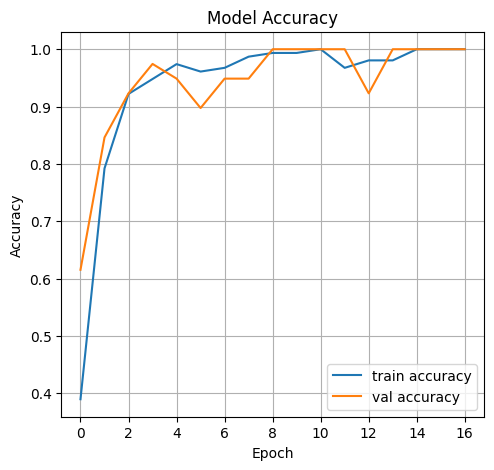

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

    # --- Loss ---


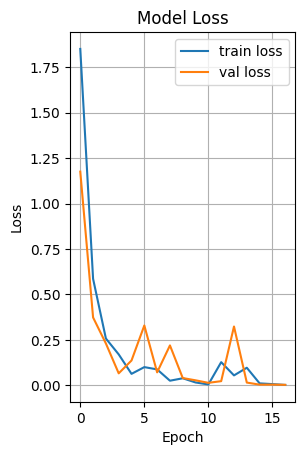

In [19]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.title('Model Loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()
  # le.# for idx, class_name in enumerate(le.classes_):
#     print(f"{class_name} → {idx}")

In [20]:
model.evaluate([x_test_img,X_landmarks_test],y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0025


[0.0024777257349342108, 1.0]

In [24]:
model.save('hand-gesture-model.keras')

In [31]:
img = np.expand_dims(x_test_img[0], axis=0)        # (1, 256, 256, 3)
lm  = np.expand_dims(X_landmarks_test[0], axis=0)  # (1, 63)

pred_idx = np.argmax(model.predict([img, lm]), axis=1)
pred_label = le.inverse_transform(pred_idx)[0]

print("Predicted:", pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
Predicted: fist
